## Suppl. Fig1 panel B Marker protein expression in cell lines

This notebook uses two datasets:
- Geiger et al. 2012, Comparative Proteomic Analysis of Eleven Common Cell Lines Reveals Ubiquitous but Varying Expression of Most Proteins
- The OpenCell dataset (Cho et al. 2022)


In [31]:
import sys, os
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))
from utils.volcano import load_volcano_data_v2

output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

plt.rcParams['pdf.fonttype'] = 42

In [32]:
remove_undetected_proteins = False

## Load 36 markers

In [33]:
timestamp = "2023-10-21-imp5-for-figures"
print(f"Timestamp: {timestamp}")

# define files to load
enrichment_dir = Path.cwd().parent.parent / "enrichment"
volcano_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f'{timestamp}_volcano_table.csv'
clusters_csv = Path.cwd().parent.parent / "Fig2" / "panel_C" / "output" / f"{timestamp}_graph-based_annotations.csv"
try:
    # load the file
    volcano_df, cluster_highlights, pulldowns, compartments = load_volcano_data_v2(volcano_csv_path, clusters_csv)
except FileNotFoundError:
    print(f"One or more of the following files are not found:\n{volcano_csv_path}\n{clusters_csv}\n")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {volcano_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

markers = [i.split("-")[1] for i in pulldowns]

# include YWHAB
markers = ["YWHAB"] + markers

print(f"Markers: {markers}")


Timestamp: 2023-10-21-imp5-for-figures
Markers: ['YWHAB', 'YWHAQ', 'ACTB', 'ATG101', 'MAP1LC3B', 'CEP350', 'VPS35', 'CLTA', 'EEA1', 'NCLN', 'CCDC47', 'RTN4', 'SEC61B', 'COPE', 'SEC23A', 'SEC31A', 'RAB1A', 'COG8', 'GPR107', 'GOLGA2', 'HSPA1B', 'HSP90AA1', 'LAMP1', 'RAB7A', 'TOMM20', 'DCP1A', 'EDC4', 'PEX3', 'CAV1', 'ATP1B3', 'SLC30A2', 'PSMB7', 'RAB14', 'RAB11A', 'RPL36', 'CAPRIN1', 'G3BP1']


## Load and process OpenCell dataset

In [34]:
oc_csv = data_path / "external" / "opencell-protein-abundance.csv"

try:
    # load the file
    oc_df = pd.read_csv(oc_csv)
except FileNotFoundError:
    print(f"One or more of the following files are not found:\n{oc_csv}\n")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {oc_csv}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [35]:
# process oc data
remove_non_detected_proteins = False

if remove_non_detected_proteins:
    oc_df = oc_df[oc_df["hek_protein_copy_number"].notna()] # remove rows with missing values in "hek_protein_copy_number"
else:
    oc_df["hek_protein_copy_number"] = oc_df["hek_protein_copy_number"].fillna(0) # fill missing values with 0

oc_df["log10(hek_protein_copy_number)"] = np.log10(oc_df["hek_protein_copy_number"])

c:\Users\duo.peng\Anaconda3\envs\OrgIP2\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
# reprocess marker list for OC data
# check if all markers are present in the OC data
markers = [i.split("-")[1] for i in pulldowns]

# for m in markers:
#     if m not in oc_df["gene_name"].values:
#         print(f"{m} not found in OC data or are not detected")
#         markers.remove(m)

# note: MAP1LC3B, COG8, HSPA1B, SLC30A2 were not detected in OC data

# compute percentile rank
if remove_non_detected_proteins:
    oc_df_detected_only = oc_df.copy()[oc_df["hek_protein_copy_number"] != 0]
    oc_df_detected_only["copy_number_percentile"] = oc_df_detected_only["hek_protein_copy_number"].rank(pct=True) * 100 
    oc_df_detected_only["copy_number_percentile"]  = oc_df_detected_only[   "copy_number_percentile"]. round(2)
    oc_gene_to_percentile = dict(zip(oc_df_detected_only["gene_name"], oc_df_detected_only["copy_number_percentile"]))
else:
    oc_df["copy_number_percentile"] = oc_df["hek_protein_copy_number"].rank(pct=True) * 100 
    oc_df["copy_number_percentile"]  = oc_df["copy_number_percentile"]. round(2)
    oc_gene_to_percentile = dict(zip(oc_df["gene_name"], oc_df["copy_number_percentile"]))

## Load the process the Geiger dataset (Gygi lab)
From paper: Quantitative Proteomics of the Cancer Cell Line Encyclopedia

In [37]:
gygi_df = pd.read_csv(data_path / "external" / "Geiger_summed_sn_non_normalized_v1.1.csv",header=0, index_col='Gene.Symbol')

In [38]:
data_cols = gygi_df.columns[46:]
data_cols = [col for col in data_cols if not col.startswith('bridge')]

In [39]:
# compute percentile rank and save it in gygi_df2
gygi_df2 = gygi_df.copy()
for c in data_cols:
    if remove_non_detected_proteins:
        # Convert 0 values to NaN
        gygi_df2[c] = gygi_df2[c].replace(0, np.nan)
    gygi_df2[c] = gygi_df[c].rank(pct=True) * 100

In [40]:
# markers 
found_markers = [m for m in markers if m in gygi_df2.index]
not_found_markers = [m for m in markers if m not in gygi_df2.index]
not_found_markers

['MAP1LC3B', 'HSPA1B', 'SLC30A2']

In [41]:
renamed_markers = ['HSPA1A', 'MAP1LC3B2']
# no matching protein found for SLC30A2 

In [42]:
# a number of gene symbols appear multiple times in the cell line table
# sort the table by the sum of abundance values, then drop the duplicate rows, keeping the ones with higher abundance
gygi_df2['sum_abundance'] = gygi_df2.loc[:,data_cols].sum(axis=1)

# drop duplicated Gene symbols, keeping the one with the highest sum of abundance
gygi_df2_filtered = gygi_df2.sort_values(by='sum_abundance', ascending=False).reset_index().drop_duplicates(subset="Gene.Symbol",keep='first').set_index("Gene.Symbol")

# before filter
print(f"Before filter: {gygi_df2.shape}")
# after filter
print(f"After filter: {gygi_df2_filtered.shape}")

Before filter: (12970, 466)
After filter: (12406, 466)


In [43]:
# revert renaming the markers
gygi_df2_filtered.rename(index={"MAP1LC3B2": "MAP1LC3B", "HSPA1A": "HSPA1B"}, inplace=True)
renamed_markers = ['HSPA1B', 'MAP1LC3B']

In [44]:
for marker in found_markers+renamed_markers:
    total_cell_lines = len(data_cols)
    missing_cell_lines = gygi_df2_filtered.loc[marker,data_cols].isna().sum()
    found_in_cell_lines = total_cell_lines - missing_cell_lines
    percent_found = float(found_in_cell_lines)/float(total_cell_lines)
    print(f"{marker:<9} found in {found_in_cell_lines}/{total_cell_lines} of cell line ({percent_found:.1%})")

YWHAQ     found in 377/377 of cell line (100.0%)
ACTB      found in 377/377 of cell line (100.0%)
ATG101    found in 323/377 of cell line (85.7%)
CEP350    found in 377/377 of cell line (100.0%)
VPS35     found in 377/377 of cell line (100.0%)
CLTA      found in 377/377 of cell line (100.0%)
EEA1      found in 377/377 of cell line (100.0%)
NCLN      found in 377/377 of cell line (100.0%)
CCDC47    found in 377/377 of cell line (100.0%)
RTN4      found in 377/377 of cell line (100.0%)
SEC61B    found in 377/377 of cell line (100.0%)
COPE      found in 377/377 of cell line (100.0%)
SEC23A    found in 377/377 of cell line (100.0%)
SEC31A    found in 377/377 of cell line (100.0%)
RAB1A     found in 377/377 of cell line (100.0%)
COG8      found in 377/377 of cell line (100.0%)
GPR107    found in 377/377 of cell line (100.0%)
GOLGA2    found in 377/377 of cell line (100.0%)
HSP90AA1  found in 377/377 of cell line (100.0%)
LAMP1     found in 377/377 of cell line (100.0%)
RAB7A     found in 37

### Plot

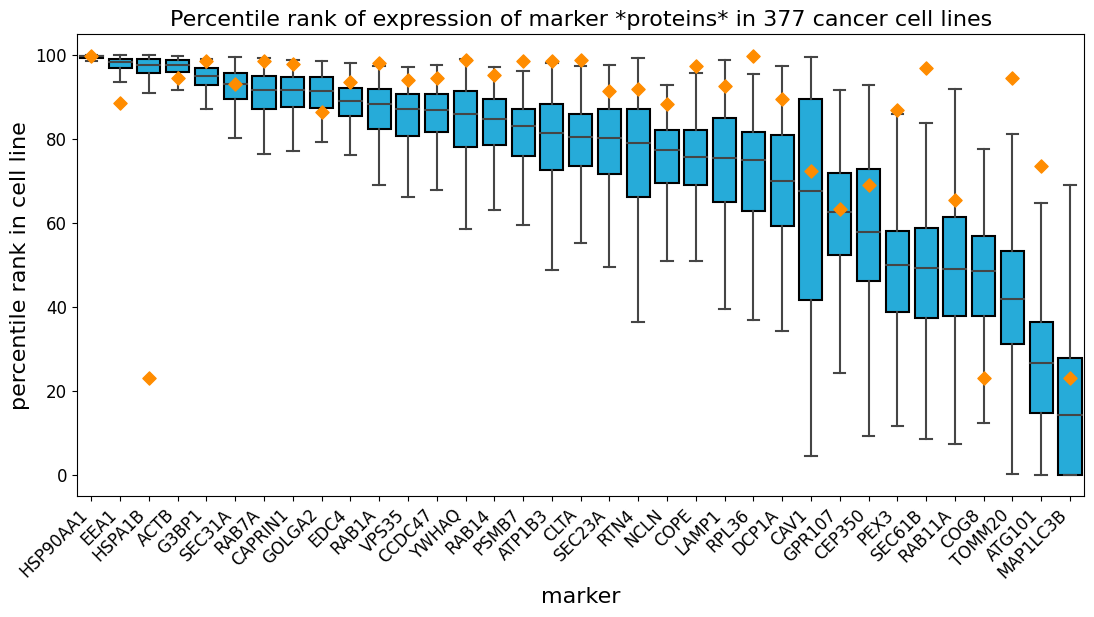

In [45]:
gygi_rows = found_markers + renamed_markers
gygi_cols = data_colsdata = (gygi_df2_filtered.loc[gygi_rows, gygi_cols]).fillna(0)

data_T = data.T
data_T.columns.name = "marker"
data_T.index.name = "cell line"

# Transforming the data to a long format suitable for boxplot
data_long = data_T.reset_index().melt(id_vars='cell line', var_name='x', value_name='y')

# Calculate the median for each x value
median_order = data_long.groupby('x')['y'].median().sort_values(ascending=False).index

# fetch the percentile rank of the marker proteins in the OC data
if remove_non_detected_proteins:
    median_order_oc = {i:oc_gene_to_percentile[i] if i in oc_gene_to_percentile else oc_df_detected_only["copy_number_percentile"].min()
                       for i in median_order}
else:
    median_order_oc = {i:oc_gene_to_percentile[i] if i in oc_gene_to_percentile else oc_df["copy_number_percentile"].min()
                       for i in median_order}

# Plotting the boxplot with the order based on the median
fig, ax = plt.subplots(figsize=(13, 6))
# Define the properties for the boxplot elements with low zorder
boxprops = dict(zorder=1, facecolor='#26abd9', edgecolor='black')
whiskerprops = dict(zorder=1)
capprops = dict(zorder=1)
medianprops = dict(zorder=1)
flierprops = dict(zorder=1)
sns.boxplot(data=data_long, x='x', y='y', order=median_order, fliersize=0, ax = ax, 
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, flierprops=flierprops)

# Adjust y-axis limits to include 0
ax.set_ylim(-5, 105)

# Adding symbols at specified (x, y) coordinates
for x, y in median_order_oc.items():
    if x in median_order:
        x_pos = list(median_order).index(x)
        ax.scatter(x_pos, y, color='darkorange', s=45, marker='D')
        #print(f"Special point for {x} at {y:.2f}")

# adding the title and labels
plt.title('Percentile rank of expression of marker *proteins* in 377 cancer cell lines', fontsize=16)
plt.xlabel('marker', fontsize=16)
plt.ylabel('percentile rank in cell line', fontsize=16)
plt.xticks(rotation=45, ha = "right", fontsize=12)  
plt.yticks(fontsize=12)
if remove_non_detected_proteins:
    plt.savefig(os.path.join(output_dir, "marker_protein_percentile_Gygi-Lab_withOC_remove_undet.pdf"), format="pdf", bbox_inches="tight", dpi=600)
else:
    plt.savefig(os.path.join(output_dir, "marker_protein_percentile_Gygi-Lab_withOC.pdf"), format="pdf", bbox_inches="tight", dpi=600)
plt.show()